In [63]:
import numpy as np
import torch.nn
import json
import os

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Set default figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
# Set image and label directory
imgs_dir = "cityscapes_samples"
labels_dir = "cityscapes_samples_labels"

# Set accepted labels for this project
label_dict = {
    "person": 1,
    "persongroup": 2,
    "rider": 3,
    "bicycle": 4,
    "bicyclegroup": 5,
    "car": 6,
    "cargroup": 7,
    "bus": 8,
    "truck": 9,
    "traffic sign": 10,
    "traffic light": 11
}

In [65]:
from vehicle_detection.cityscape_datalist import *

# Create a data list of images
cs_data_list = CityScapeDatalist(imgs_dir, labels_dir, label_dict)
cs_data_list.prepare_data_list()

# Split data into train test and validation
cs_data_list.split_data()

In [66]:
# TODO: Plot sample images
cs_data_list.data_list[0]

{'img_path': 'cityscapes_samples/bad-honnef/bad-honnef_000000_000013_leftImg8bit.png',
 'labels': array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  6,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0, 10, 10,  0,  0,  0,  0,  0,  0,
        10, 10, 10, 10,  0,  0,  0,  0,  0,  0,  0]),
 'bounding_boxes': array([[1.700e+01, 4.110e+02, 2.035e+03, 1.020e+03],
        [7.000e+00, 4.540e+02, 6.260e+02, 9.540e+02],
        [1.000e+00, 4.060e+02, 3.290e+02, 5.930e+02],
        [4.270e+02, 1.530e+02, 4.440e+02, 5.990e+02],
        [1.330e+02, 7.000e+00, 4.090e+02, 4.270e+02],
        [5.900e+02, 3.600e+01, 6.180e+02, 4.860e+02],
        [7.350e+02, 1.000e+00, 9.820e+02, 2.400e+02],
        [8.740e+02, 2.000e+00, 1.084e+03, 2.040e+02],
        [6.280e+02, 4.000e+00, 7.420e+02, 2.820e+02],
        [4.520e+02, 4.000e+00, 5.920e+02, 3.200e+02],
        [1.062e+03, 8.000e+00, 1.281e+03, 3.060e+02],
        [1.180e+03, 2.170e+02, 1.348e+03, 4.010e+02],
        [1.373e+03, 2.080e+02, 

In [67]:
from vehicle_detection.cityscape_dataset import *
from vehicle_detection.solver import *

# Create a dataset using the data list you prepared
train_dataset = CityScapeDataset(cs_data_list.train_list)
valid_dataset = CityScapeDataset(cs_data_list.valid_list)

# Create a solver to train the model
solver = Solver(train_dataset, valid_dataset, batch_size=32)


In [68]:
# Sanity check on a sample of data loader
with torch.no_grad():
    # Now I'm going to read a few data examples from the DataLoader and plot them
    idx, (img, bbox_tensor, bbox_label_tensor) = next(enumerate(solver.train_loader))
    
    print("Image shape is of shape: {}".format(img.shape))
    print("bbox_tensor is of shape {}".format(bbox_tensor.shape))
    print("bbox_label_tensor is of shape: {}".format(bbox_label_tensor.shape))
    print(bbox_label_tensor.sum())

Image shape is of shape: torch.Size([32, 3, 300, 300])
bbox_tensor is of shape torch.Size([32, 2982, 4])
bbox_label_tensor is of shape: torch.Size([32, 2982])
tensor(30)


In [115]:
from vehicle_detection.ssd_net import *
from vehicle_detection.bbox_loss import *

# Instantiate the model
num_classes = len(label_dict) + 1
ssd_net = SSD(num_classes).cpu()

# Create an optimizer
optimizer = torch.optim.Adam(ssd_net.parameters(), lr=1e-4)

# Initialize loss function
loss_function = MultiboxLoss()

In [ ]:
# Training the model
rain_class_loss, train_bbox_loss, valid_class_loss, valid_bbox_loss = solver.train(ssd_net.cpu(), 
                                                                                   optimizer, 
                                                                                   loss_function)

This is epoch 0
torch.float32
torch.int64


[580 275] [599 346]
[580 275 599 346]
[1080  330] [1112  450]
[1080  330 1112  450]


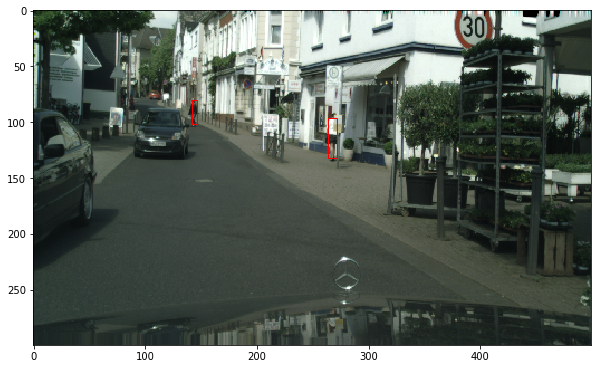

In [138]:
# Helper function for resizing the image and bounding box
input_dim = (500, 300)
def resize(img, bbox):
    w, h = img.size
    w_ratio = input_dim[0] / float(w)
    h_ratio = input_dim[1] / float(h)
    bbox[:, 0] *= w_ratio
    bbox[:, 1] *= h_ratio
    return bbox

# Plot the image
img = Image.open(imgPath)
fig,ax = plt.subplots(1)
new_img = img.resize(input_dim)
ax.imshow(new_img)

# Find the bounding box
with open(labelPath, 'r') as data:
    for item in json.load(data)['objects']:
#         print(item['label'])
        if item['label'] in {'person'}:#{'person', 'car', 'traffic sign', 'bicycle'}:
            topLeft = np.min(item['polygon'], axis=0)
            bottomRight = np.max(item['polygon'], axis=0)
            print(topLeft, bottomRight)
            print(np.concatenate((topLeft, bottomRight)))
            bbox = resize(img, np.asarray([topLeft, bottomRight], dtype=np.float64))
            width = bbox[1][0] - bbox[0][0]
            height = bbox[1][1] - bbox[0][1]
            rect = patches.Rectangle(bbox[0], width, height,linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)


In [24]:
labels

{'imgHeight': 1024,
 'imgWidth': 2048,
 'objects': [{'label': 'vegetation',
   'polygon': [[934, 8],
    [417, 19],
    [355, 97],
    [355, 107],
    [429, 173],
    [450, 180],
    [668, 216],
    [775, 221],
    [1021, 267],
    [1033, 180],
    [946, 74]]},
  {'label': 'sky',
   'polygon': [[1198, 11],
    [1000, 16],
    [1016, 50],
    [1020, 53],
    [1070, 61],
    [1077, 26],
    [1102, 26],
    [1102, 51],
    [1123, 51],
    [1148, 35],
    [1180, 37]]},
  {'label': 'vegetation',
   'polygon': [[1975, 27],
    [1665, 25],
    [1662, 142],
    [1762, 115],
    [1892, 123],
    [1980, 146],
    [1998, 46]]},
  {'label': 'vegetation',
   'polygon': [[1564, 33],
    [1475, 24],
    [1416, 67],
    [1430, 92],
    [1447, 149],
    [1462, 155],
    [1591, 162],
    [1612, 98],
    [1591, 17]]},
  {'label': 'pole',
   'polygon': [[1621, 18], [1637, 19], [1632, 659], [1614, 656]]},
  {'label': 'fence',
   'polygon': [[1694, 483], [1648, 472], [1645, 656], [1700, 769]]},
  {'label': 

In [89]:
a.index_fill_(0, torch.from_numpy(np.asarray([1])), 2)

tensor([-0.9922,  2.0000, -0.5156, -0.6406, -0.7109, -0.6250, -0.7109, -0.6406,
        -0.4453, -0.3203])

In [25]:
a = img[0,1]

In [27]:
a[[0,1]].shape

torch.Size([2, 300])